In [1]:
import tensorflow as tf
from tensorflow.keras import models, layers
import matplotlib.pyplot as plt
import seaborn as sn
import numpy as np
import joblib    
import pickle
from sklearn.metrics import confusion_matrix, classification_report

In [2]:
IMAGE_SIZE=256
BATCH_SIZE=32
CHANNELS=3
EPOCHS=20

In [3]:
dataset=tf.keras.preprocessing.image_dataset_from_directory(
    "D:\Ishita\IGDTUW (CSE)\Summer Internship 2023\Potato",
    shuffle=True,
    image_size=(IMAGE_SIZE,IMAGE_SIZE),
    batch_size=BATCH_SIZE
)

Found 1500 files belonging to 3 classes.


In [4]:
class_names=dataset.class_names
class_names

['Potato___Early_blight', 'Potato___Late_blight', 'Potato___healthy']

In [5]:
len(dataset)

47

(32, 256, 256, 3)
[2 1 1 2 1 2 1 1 2 2 1 2 1 0 1 0 1 0 0 2 2 0 2 1 2 0 1 0 0 2 2 1]


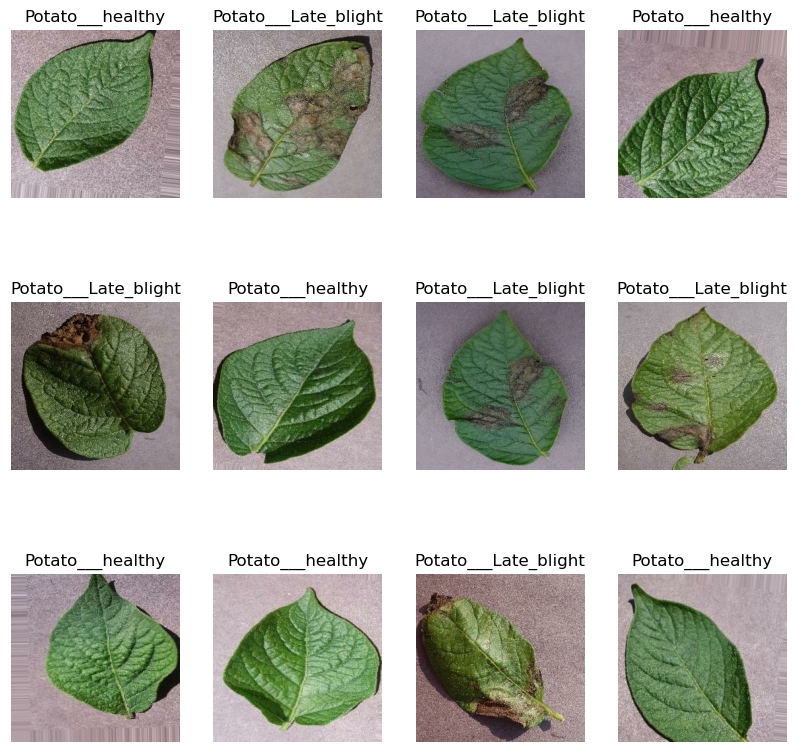

In [6]:
plt.figure(figsize=(10,10))
for image_batch, label_batch in dataset.take(1):
    print(image_batch.shape)
    print(label_batch.numpy())
    for i in range(12):
        ax=plt.subplot(3,4,i+1)
        plt.imshow(image_batch[i].numpy().astype("uint8"))
        plt.title(class_names[label_batch[i]])
        plt.axis("off")

In [7]:
def get_dataset_partitions_tf(ds, train_split=0.5, val_split=0.25, test_split=0.25, shuffle=True, shuffle_size=10000):
    ds_size=len(ds)
    if shuffle:
        ds=ds.shuffle(shuffle_size, seed=12)
    train_size=int(train_split*ds_size)
    val_size=int(val_split*ds_size)
    train_ds=ds.take(train_size)
    val_ds=ds.skip(train_size).take(val_size)
    test_ds=ds.skip(train_size).skip(val_size)
    return train_ds, val_ds, test_ds
train_ds, val_ds, test_ds=get_dataset_partitions_tf(dataset)

In [8]:
print(len(train_ds), len(val_ds), len(test_ds))

23 11 13


In [9]:
train_ds=train_ds.cache().shuffle(1000).prefetch(buffer_size=tf.data.AUTOTUNE)
val_ds=val_ds.cache().shuffle(1000).prefetch(buffer_size=tf.data.AUTOTUNE)
test_ds=test_ds.cache().shuffle(1000).prefetch(buffer_size=tf.data.AUTOTUNE)

In [10]:
resize_and_rescale=tf.keras.Sequential([
    layers.experimental.preprocessing.Resizing(IMAGE_SIZE,IMAGE_SIZE),
    layers.experimental.preprocessing.Rescaling(1.0/255)
])
data_augmentation=tf.keras.Sequential([
    layers.experimental.preprocessing.RandomFlip("horizontal_and_vertical"),
    layers.experimental.preprocessing.RandomRotation(0.2)
])

In [11]:
input_shape=(BATCH_SIZE, IMAGE_SIZE, IMAGE_SIZE, CHANNELS)
n_classes=3
model=models.Sequential([
    resize_and_rescale,
    data_augmentation,
    layers.Conv2D(32, (3,3), activation='relu', input_shape=input_shape),
    layers.MaxPooling2D((2,2)),
    layers.Conv2D(64, (3,3), activation='relu'),
    layers.MaxPooling2D((2,2)),
    layers.Conv2D(64, (3,3), activation='relu'),
    layers.MaxPooling2D((2,2)),
    layers.Conv2D(64, (3,3), activation='relu'),
    layers.MaxPooling2D((2,2)),
    layers.Conv2D(64, (3,3), activation='relu'),
    layers.MaxPooling2D((2,2)),
    layers.Conv2D(64, (3,3), activation='relu'),
    layers.MaxPooling2D((2,2)),
    layers.Flatten(),
    layers.Dense(64, activation='relu'),
    layers.Dense(n_classes, activation='softmax')
])
model.build(input_shape=input_shape)
model.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 sequential (Sequential)     (32, 256, 256, 3)         0         
                                                                 
 sequential_1 (Sequential)   (32, 256, 256, 3)         0         
                                                                 
 conv2d (Conv2D)             (32, 254, 254, 32)        896       
                                                                 
 max_pooling2d (MaxPooling2D  (32, 127, 127, 32)       0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (32, 125, 125, 64)        18496     
                                                                 
 max_pooling2d_1 (MaxPooling  (32, 62, 62, 64)         0         
 2D)                                                  

In [12]:
model.compile(
    optimizer='adam',
    loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=False),
    metrics=['accuracy']
)
history=model.fit(
    train_ds,
    epochs=EPOCHS,
    batch_size=BATCH_SIZE,
    verbose=1,
    validation_data=val_ds
)

Epoch 1/20
23/23 [==============================] - 28s 1s/step - loss: 1.0692 - accuracy: 0.3899 - val_loss: 1.0650 - val_accuracy: 0.2955
Epoch 2/20
23/23 [==============================] - 26s 1s/step - loss: 0.7958 - accuracy: 0.6128 - val_loss: 0.6755 - val_accuracy: 0.6591
Epoch 3/20
23/23 [==============================] - 28s 1s/step - loss: 0.5633 - accuracy: 0.7500 - val_loss: 0.4594 - val_accuracy: 0.8011
Epoch 4/20
23/23 [==============================] - 28s 1s/step - loss: 0.5746 - accuracy: 0.7459 - val_loss: 0.4460 - val_accuracy: 0.7983
Epoch 5/20
23/23 [==============================] - 29s 1s/step - loss: 0.4432 - accuracy: 0.8125 - val_loss: 0.5806 - val_accuracy: 0.7557
Epoch 6/20
23/23 [==============================] - 30s 1s/step - loss: 0.4281 - accuracy: 0.8261 - val_loss: 0.5946 - val_accuracy: 0.7472
Epoch 7/20
23/23 [==============================] - 31s 1s/step - loss: 0.4414 - accuracy: 0.8152 - val_loss: 0.3567 - val_accuracy: 0.8409
Epoch 8/20
23/23 [==

In [13]:
scores=model.evaluate(test_ds)
scores

13/13 [==============================] - 3s 213ms/step - loss: 0.1043 - accuracy: 0.9636


[0.10430409759283066, 0.9635922312736511]

In [14]:
history.history['loss']

[1.069164752960205,
 0.7958030700683594,
 0.5633246302604675,
 0.5745701789855957,
 0.44322535395622253,
 0.42805415391921997,
 0.441362589597702,
 0.3091679811477661,
 0.24230363965034485,
 0.26919108629226685,
 0.2608411908149719,
 0.16762800514698029,
 0.2089352160692215,
 0.12043682485818863,
 0.13390323519706726,
 0.0891527608036995,
 0.11406829208135605,
 0.15296286344528198,
 0.4166414737701416,
 0.11287244409322739]

In [15]:
history.history['accuracy']

[0.3899456560611725,
 0.61277174949646,
 0.75,
 0.7459239363670349,
 0.8125,
 0.8260869383811951,
 0.8152173757553101,
 0.8695651888847351,
 0.8926630616188049,
 0.8885869383811951,
 0.904891312122345,
 0.9442934989929199,
 0.9198369383811951,
 0.9633151888847351,
 0.948369562625885,
 0.967391312122345,
 0.95652174949646,
 0.94972825050354,
 0.83423912525177,
 0.9660326242446899]

In [16]:
history.history['val_loss']

[1.065039873123169,
 0.675499677658081,
 0.4594215452671051,
 0.4459989666938782,
 0.5805825591087341,
 0.5946238040924072,
 0.3566654920578003,
 0.29754769802093506,
 0.2888193726539612,
 0.3441842496395111,
 0.27163898944854736,
 0.15395575761795044,
 0.13145245611667633,
 0.42463207244873047,
 0.1669859141111374,
 0.22651657462120056,
 0.31692370772361755,
 1.5630298852920532,
 0.12448012828826904,
 0.13240991532802582]

In [17]:
history.history['val_accuracy']

[0.2954545319080353,
 0.6590909361839294,
 0.8011363744735718,
 0.7982954382896423,
 0.7556818127632141,
 0.7471590638160706,
 0.8409090638160706,
 0.8721590638160706,
 0.8721590638160706,
 0.8522727489471436,
 0.8863636255264282,
 0.9488636255264282,
 0.9545454382896423,
 0.8409090638160706,
 0.9488636255264282,
 0.9176136255264282,
 0.8778409361839294,
 0.5994318127632141,
 0.9403409361839294,
 0.9715909361839294]

In [18]:
acc=history.history['accuracy']
val_acc=history.history['val_accuracy']
loss=history.history['loss']
val_loss=history.history['val_loss']

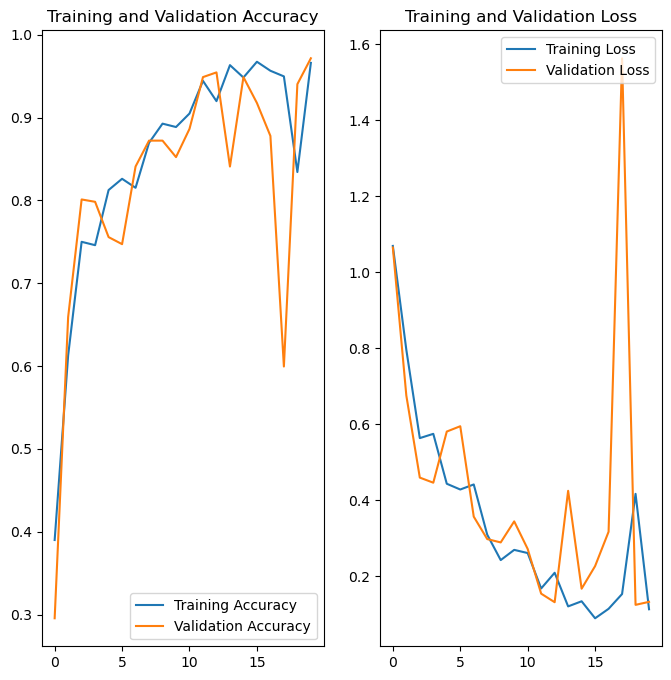

In [19]:
plt.figure(figsize=(8,8))
plt.subplot(1,2,1)
plt.plot(range(EPOCHS), acc, label='Training Accuracy')
plt.plot(range(EPOCHS), val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1,2,2)
plt.plot(range(EPOCHS), loss, label='Training Loss')
plt.plot(range(EPOCHS), val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')

plt.show()

In [20]:
true_labels = []
pred_labels = []
for images_batch, labels_batch in test_ds.take(13):
    batch_prediction=model.predict(images_batch).argmax(axis=1)
    for i in labels_batch:
        true_labels.append(i)
    for i in batch_prediction:
        pred_labels.append(i)

1/1 [==============================] - 0s 294ms/step


In [21]:
def predict(model, img):
    img_array=tf.keras.preprocessing.image.img_to_array(images[i].numpy())
    img_array=tf.expand_dims(img_array,0)
    predictions=model.predict(img_array)
    predicted_class=class_names[np.argmax(predictions[0])]
    confidence=round(100*(np.max(predictions[0])),2)
    return predicted_class, confidence

1/1 [==============================] - 0s 31ms/step


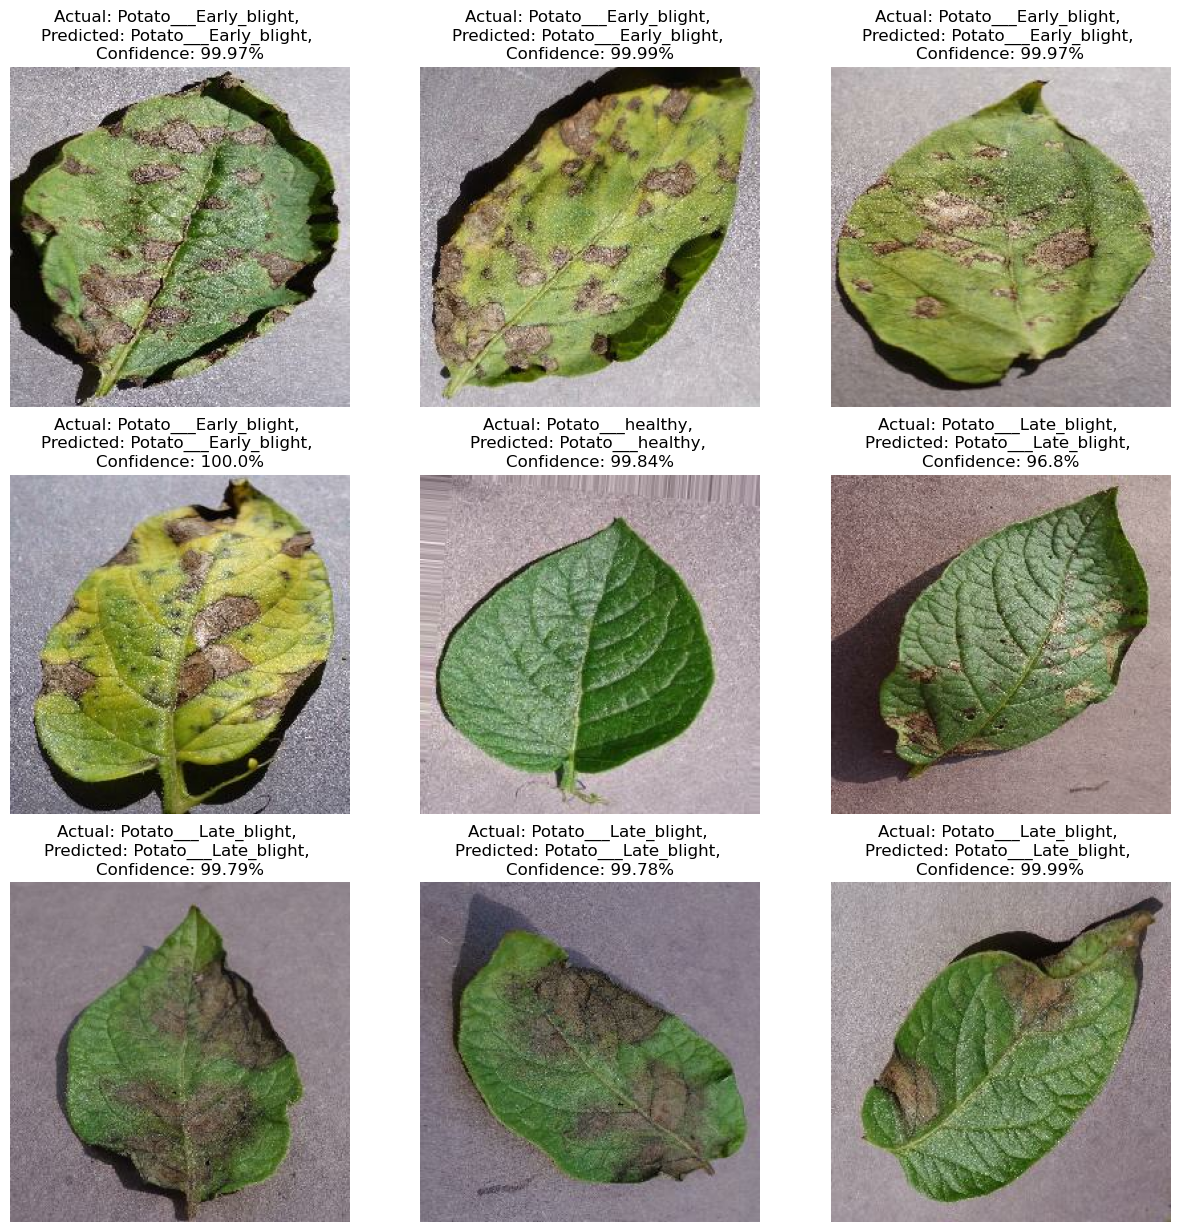

In [22]:
plt.figure(figsize=(15,15))
for images, labels in test_ds.take(1):
    for i in range(9):
        ax=plt.subplot(3,3,i+1)
        plt.imshow(images[i].numpy().astype("uint8"))
        predicted_class, confidence=predict(model,images[i].numpy())
        actual_class=class_names[labels[i]]
        plt.title(f"Actual: {actual_class}, \nPredicted: {predicted_class}, \nConfidence: {confidence}%")
        plt.axis("off")

In [23]:
print ("Classification Report: \n", classification_report(true_labels, pred_labels))

Classification Report: 
               precision    recall  f1-score   support

           0       0.92      1.00      0.96       137
           1       1.00      0.89      0.94       135
           2       0.98      1.00      0.99       140

    accuracy                           0.96       412
   macro avg       0.97      0.96      0.96       412
weighted avg       0.97      0.96      0.96       412



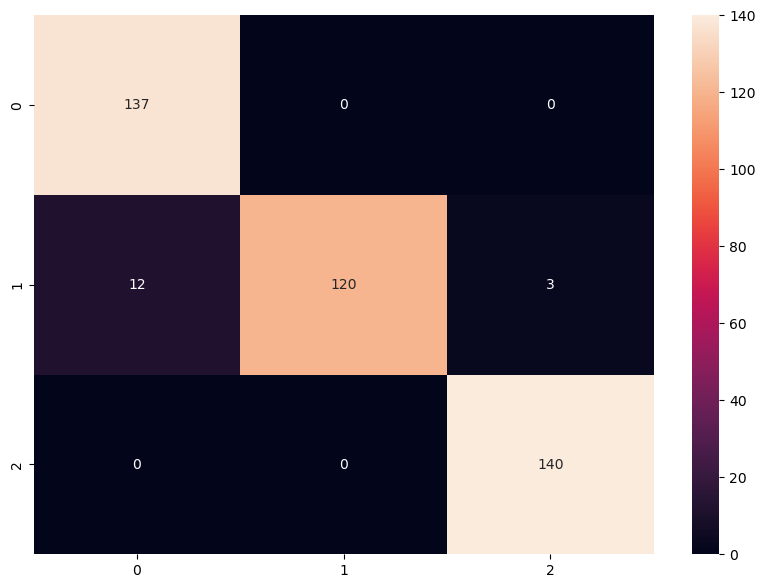

In [24]:
cm=tf.math.confusion_matrix(true_labels, pred_labels)
plt.figure(figsize=(10,7))
sn.heatmap(cm,annot=True,fmt='d')
plt.xlabel=('Predicted')
plt.ylabel=('Truth')

In [25]:
filename = "Model1-2-DatasetSplit50-25-25.joblib"
joblib.dump(model, filename)

['Model1-2-DatasetSplit50-25-25.joblib']